Loan Prediction practice

Date: March 03, 2017

Project Description:
Company wants to automate the loan eligibility process (real time) based on customer detail provided
while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents,
Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the 
customers segments, those are eligible for loan amount so that they can specifically target these customers.Here they have provided a partial data set.

Part 3: Using Logistic regression with imputation.


In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from IPython.display import display

from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score,auc

In [2]:
data=pd.read_csv('train_data.csv')
display(data.head(1))
print "Training dataset has {} samples with {} features.".format(*data.shape)

train_features=data.drop(['Loan_Status'],1)
train_labels=data['Loan_Status']

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y


Training dataset has 614 samples with 13 features.


Data Processing:

In [3]:
#Create dummy variables for categorical variables
dummies = pd.get_dummies(train_features['Property_Area'], prefix='Property_Area')
train_features_recode=train_features.join(dummies).drop(['Property_Area','Property_Area_Rural'],1)

In [4]:
#Check missing values for all variables
def num_missing(x):
    return sum(x.isnull())

data.apply(num_missing,axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
#Fill in missing data
#1. Using mode to fill Gender, Loan_Amount_term, self-employed, married
from scipy.stats import mode
train_features_recode['Gender'].fillna(mode(data['Gender']).mode[0],inplace=True)
train_features_recode['Self_Employed'].fillna(mode(data['Self_Employed']).mode[0],inplace=True)
train_features_recode['Married'].fillna(mode(data['Married']).mode[0],inplace=True)
train_features_recode['Loan_Amount_Term'].fillna(mode(data['Loan_Amount_Term']).mode[0],inplace=True)

#2. Dependents: using mean group by 'Married'
#print pd.crosstab(data['Married'],data['Dependents'],margins=True)
#print data.groupby('Married')['Dependents'].mean()

#3. Using mean to fill in Loan amount 
train_features_recode['LoanAmount'].fillna(data['LoanAmount'].mean(),inplace=True)

#4. Credit history if missing set to 0(no history. Being conservetive.)
train_features_recode['Credit_History'].fillna(0,inplace=True)

/Users/xiaohui/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/xiaohui/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [6]:
#Coding LoanStatus as Y=1, N=0:
#Create a generic function to recode variables using replace function:
def coding(col, coldict):
    colnew=pd.Series(col, copy=True)
    for key, value in coldict.items():
        colnew.replace(key, value, inplace=True) #what does inplace do?
    return colnew

train_features_recode['Gender_coded']=coding(train_features_recode['Gender'],{'Male':0,'Female':1})
train_features_recode['Married_coded']=coding(train_features_recode['Married'],{'Yes':0,'No':1})
train_features_recode['Education_coded']=coding(train_features_recode['Education'],{'Not Graduate':0,'Graduate':1})
train_features_recode['Self_Employed_coded']=coding(train_features_recode['Self_Employed'],{'Yes':0,'No':1})
train_features_recode['Dependents_coded']=coding(train_features_recode['Dependents'],{'0':0,'1':1,'2':2,'3+':3})
train_features_recode.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Semiurban,Property_Area_Urban,Gender_coded,Married_coded,Education_coded,Self_Employed_coded,Dependents_coded
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,0.0,1.0,0,1,1,1,0.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,0.0,0.0,0,0,1,1,1.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,0.0,1.0,0,0,1,0,0.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,0.0,1.0,0,0,0,1,0.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,0.0,1.0,0,1,1,1,0.0


In [7]:
#2. Fill in blank for Dependents: using group mean of dependents by 'Married'

#check group mean by 'Married'
print pd.crosstab(data['Married'],data['Dependents'],margins=True)
print train_features_recode.groupby('Married')['Dependents_coded'].mean()
 
print "Missing count and frequency counts before imputation"
print pd.value_counts(train_features_recode['Dependents_coded'])
print sum(train_features_recode['Dependents_coded'].isnull())
print pd.value_counts(train_features_recode.loc[(train_features_recode['Dependents_coded'].isnull() ), 'Married'])
                          
#Fill in blank for 'Dependents_coded'                      
train_features_recode.loc[(train_features_recode['Dependents_coded'].isnull() ) & (train_features_recode['Married']=='Yes'), 'Dependents_coded']=train_features_recode.groupby('Married')['Dependents_coded'].mean()[1]
train_features_recode.loc[(train_features_recode['Dependents_coded'].isnull() ) & (train_features_recode['Married']=='No'), 'Dependents_coded']=train_features_recode.groupby('Married')['Dependents_coded'].mean()[0]


print pd.value_counts(train_features_recode['Dependents_coded'])
print sum(train_features_recode['Dependents_coded'].isnull())

Dependents    0    1    2  3+  All
Married                           
No          171   23    8   7  213
Yes         174   79   93  44  398
All         345  102  101  51  614
Married
No     0.287081
Yes    1.017949
Name: Dependents_coded, dtype: float64
Missing count and frequency counts before imputation
0.0    345
1.0    102
2.0    101
3.0     51
Name: Dependents_coded, dtype: int64
15
Yes    11
No      4
Name: Married, dtype: int64
0.000000    345
1.000000    102
2.000000    101
3.000000     51
1.017949     11
0.287081      4
Name: Dependents_coded, dtype: int64
0


In [8]:
#final check for missing value
print train_features_recode.apply(num_missing,axis=0)

Loan_ID                     0
Gender                      0
Married                     0
Dependents                 15
Education                   0
Self_Employed               0
ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                  0
Loan_Amount_Term            0
Credit_History              0
Property_Area_Semiurban     0
Property_Area_Urban         0
Gender_coded                0
Married_coded               0
Education_coded             0
Self_Employed_coded         0
Dependents_coded            0
dtype: int64


In [9]:
#Build logistic regression model to predict loan_status
logreg_train_feature=train_features_recode.drop(['Loan_ID','Gender','Married','Education','Self_Employed','Dependents'],1)
logreg_train_label=train_labels

In [10]:
loan_model=LogisticRegression()
loan_model.fit(logreg_train_feature,logreg_train_label)
print loan_model.score(logreg_train_feature,logreg_train_label)
coefficient=pd.DataFrame(loan_model.coef_.transpose(),columns=['coefficient'],index=logreg_train_feature.columns).sort_values(['coefficient'],ascending=False)
coefficient

0.771986970684


,coefficient
Credit_History,2.020007
Property_Area_Semiurban,0.662704
Education_coded,0.331657
Property_Area_Urban,0.128958
Gender_coded,0.035389
ApplicantIncome,-0.000002
CoapplicantIncome,-0.000038
LoanAmount,-0.001200
Loan_Amount_Term,-0.001790
Dependents_coded,-0.041484


In [11]:
y=coding(logreg_train_label,{'Y':1,'N':0})
print confusion_matrix(logreg_train_label, loan_model.predict(logreg_train_feature),labels=['Y','N'])
print "Logistic regression model has an ROC-AUC score of {:.4f}.".format(roc_auc_score(y, loan_model.predict_proba(logreg_train_feature)[:,1]))

[[381  41]
 [ 99  93]]
Logistic regression model has an ROC-AUC score of 0.7655.


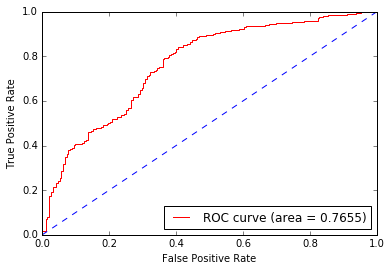

In [12]:
preds = loan_model.predict_proba(logreg_train_feature)[:,1]
fpr, tpr, thres = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='b', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [13]:
#prepare output for test data
#Processing test datasets
#1.create dummy variables
test=pd.read_csv('test_data.csv')
dummies = pd.get_dummies(test['Property_Area'], prefix='Property_Area')
test_recode=test.join(dummies).drop(['Property_Area','Property_Area_Rural'],1)


#2a.Impute missing values
# (1). Using mode to fill Gender, Loan_Amount_term, self-employed, married
from scipy.stats import mode
test_recode['Gender'].fillna(mode(data['Gender']).mode[0],inplace=True)
test_recode['Self_Employed'].fillna(mode(data['Self_Employed']).mode[0],inplace=True)
test_recode['Married'].fillna(mode(data['Married']).mode[0],inplace=True)
test_recode['Loan_Amount_Term'].fillna(mode(data['Loan_Amount_Term']).mode[0],inplace=True)


#(2). Dependents: using mean group by 'Married'
#print pd.crosstab(data['Married'],data['Dependents'],margins=True)
#print data.groupby('Married')['Dependents'].mean()

#(3). Using mean to fill in Loan amount 
test_recode['LoanAmount'].fillna(data['LoanAmount'].mean(),inplace=True)

#(4). Credit history if missing set to 0(no history. Being conservetive.)
test_recode['Credit_History'].fillna(0,inplace=True)


#3. recode categorical variables

test_recode['Gender_coded']=coding(test_recode['Gender'],{'Male':0,'Female':1})
test_recode['Married_coded']=coding(test_recode['Married'],{'Yes':0,'No':1})
test_recode['Education_coded']=coding(test_recode['Education'],{'Not Graduate':0,'Graduate':1})
test_recode['Self_Employed_coded']=coding(test_recode['Self_Employed'],{'Yes':0,'No':1})
test_recode['Dependents_coded']=coding(test_recode['Dependents'],{'0':0,'1':1,'2':2,'3+':3})
test_recode.head()

#2b. Impute "dependents.
#Fill in blank for 'Dependents_coded'                      
test_recode.loc[(test_recode['Dependents_coded'].isnull() ) & (test_recode['Married']=='Yes'), 'Dependents_coded']=train_features_recode.groupby('Married')['Dependents_coded'].mean()[1]
test_recode.loc[(test_recode['Dependents_coded'].isnull() ) & (test_recode['Married']=='No'), 'Dependents_coded']=train_features_recode.groupby('Married')['Dependents_coded'].mean()[0]

#

#4. Making prediction using fitted logistic regression model
logreg_test_feature=test_recode.drop(['Loan_ID','Gender','Married','Education','Self_Employed','Dependents'],1)
py=loan_model.predict(logreg_test_feature)
test_recode['Loan_Status']=py
print test_recode.shape
print display(test_recode.head())

submission=test_recode.loc[:,['Loan_ID','Loan_Status']]
print submission.shape
print submission.apply(num_missing,axis=0)
print display(submission.head(5))
submission.to_csv('test_result_log_imp_0302',header=True,index = False)


(367, 19)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Semiurban,Property_Area_Urban,Gender_coded,Married_coded,Education_coded,Self_Employed_coded,Dependents_coded,Loan_Status
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,0.0,1.0,0,0,1,1,0.0,Y
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,0.0,1.0,0,0,1,1,1.0,Y
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,0.0,1.0,0,0,1,1,2.0,Y
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,0.0,0.0,1.0,0,0,1,1,2.0,N
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,0.0,1.0,0,1,0,1,0.0,Y


None
(367, 2)
Loan_ID        0
Loan_Status    0
dtype: int64


,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,N
4,LP001051,Y


None


Testing final score using logistic regression with imputation (mode/median/mean method) is 0.76388 (0.756 without imputation). 

Next step: try random forest model to seek better fitting.